# Lab Assignment 3: Medical Image Registration


In [1]:
import nibabel as nib
from nilearn import plotting
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.measure import shannon_entropy
from scipy.optimize import minimize
from sklearn.metrics import mutual_info_score

## Introduction

Image Registration is the technique that allows to align two or more images searching for the geometric transformation that puts these images into spatial concordance. This is done to overlay images from various imaging equipment or sensors taken at different times and angles, or from the same scene to geometrically align the images for analysis. To summarize, it is the process of transforming different sets of data into one coordinate system. 

This previously explained registration technique is used for the joint analysis of images, or to characterize the differences between these images. Besides, it is necessary in order to be able to compare or integrate the data obtained from different kind of measurements.

## Implementation of a registration algorithm

In this practice the objetive is to create a registration algorithm that allows the alignment of two different images for its posterior analysis. In order to implement the algorithm we need two different images, the **fixed one** (the reference image) and the **image that is needed to be aligned**. The procedure is to take an image of the volumnes used in the previous sections, apply a known offset and then try to recover the original image.

The implementation of the registration algorithm is going to be done in 2D images in order to simplify and reduce the computational load that is produced when using 3D images.
Image that is going to be used in order to create this rigid registration algorithm is a 2D image extracted from the MR Brain volumes used in the previous section.

There are two different ways to obtain 2D images from the 3D images given:

- Take any slice of one of the volumes (for example 'mr1.nii') used in the previous section.

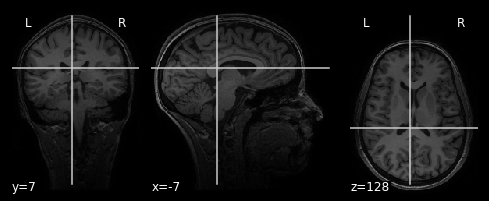

In [2]:
mr1 = nib.load('mr1.nii')
plotting.plot_anat(mr1)

In [3]:
data_mr1 = mr1.get_fdata()

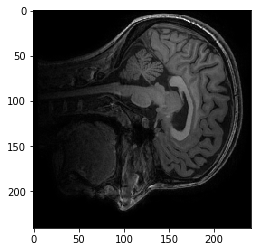

In [4]:
x_mr1 = data_mr1[-80,:,:]
plt.imshow(x_mr1, cmap='gray')
plt.show()

However, when using this method the resulting image is not very accurate to the real anatomical structure and the registration algorithm implementation using this image is much more difficult and with worse results. 

- For this reason, we have decided to use a picture taken of one of the volumes that gives a more accurate result and besides, it is easier to work with. This image is saved as 'mr1.PNG'.

**ORIGINAL IMAGE**

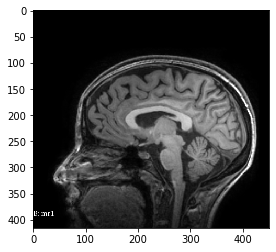

In [5]:
image_o = cv2.imread('mr1.PNG',0) #This is the image taken from the mr1 brain volume.
plt.imshow(image_o, cmap=plt.cm.gray)
plt.show()

The original image is going to be the reference or fixed image. Then, we are going to transform this original image to create the transformed image. The goal is to be able to registrate the transformed image until recover this original one.

**TRANSFORMED IMAGE**

As explained before, thanks to the original image we are going to create a transformed image that is going to be used to create the registration algorithm and try to recover the original image from it.

In order to create a transformed image with respect to the original one, we are going to apply a **rigid transformation**. This transformation applied in a 2D image result in 4 different deformations: one rotation in the x-axis, one rotation in the y-axis, **one translation in the x-axis and finally, one translation in the y-axis**.

However, due to the functioning of the rotate function in Python, **rotation is only applied in one axis**. So the resulting parameters are going to be 3 instead of 4.

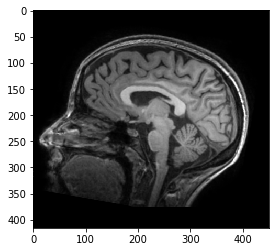

In [6]:
# Rigid Transformation.

### ROTATION
rot = rotate(image_o, -10)

### TRANSLATION
rows,cols = image_o.shape
M = np.float32([[1,0,-10],[0,1,-40]])

### TRANSFORMED IMAGE
image_mod = cv2.warpAffine(rot,M,(cols,rows))
plt.imshow(image_mod, cmap=plt.cm.gray)
plt.show()

In the previous Rigid Transformation we have selected certain parameters to apply the rotation and translation. These parameters (-10,-10,-40) have been choosen because it has been demostrated that they are the ones that result in a better registration performance.

**ALGORITHM**

Once we have fixed image and transformed image we are ready to create a registration algorithm in order to align them. This registration function is going to be composed by different parts:

- 1. Transform: RigidTransformation function applies a rigid transformation to an original image with the parameters passed to it as inputs.

In [7]:
### This function corresponds to the Rigid Transformation (Rotation + Translation)

##img - image which will be transformed
##v_rot - rotational angle
##v_x_trans - shift in the x-axis
##v_y_trans - shift in the y-axis 

def RigidTransformation(img, v_rot,v_x_trans,v_y_trans):
    #We apply the rotation
    rot = rotate(img, v_rot) 
    
    #We apply the translation
    rows,cols = rot.shape

    M = np.float32([[1,0,v_x_trans],[0,1,v_y_trans]])
    transformed = cv2.warpAffine(rot,M,(cols,rows))
    
    return transformed

- 2. Interpolation: Bilinear interpolation applied to the transformed image.

In some cases when transforming the original image into a transformed one a resize or distort of the image from one pixel grid to another is created. In these cases interpolation is necessary to correct this distorsion.

However, in our case, the applied functions rotate and warpAffine incorporate a interpolation. So, it is not necessary to us interpolate again as it has been already done.

The last two parts of the algorithm are going to be done together:


- 3. Metric: Function that calculates the mutual information metric from the two images.
- 4. Optimization: Optimization function that we will use to optimize the transformation parameters in each iteration.

In [8]:
###This function corresponds to the final registration. It means it will find the optimal parameters 
#for the modified image so that it will be properly aligned to the original image.

##img0 - the original image 
##img - the modified image

def Registration(img0,img):
    
    oned_or = img0.ravel() #We convert the original image into a one dimention image so that we can work 
                            #with it in the mutual information function
    modified = img
    
    #This funtion is the one that will be optimized. It corresponds to the mutual information. 
    #Therefore, we will try to get the maximum value of this mutuality. 
    #Being x the array that will have the three different parameters.
    def MutualInfo(x):
    
        RT = RigidTransformation(modified,x[0],x[1],x[2])
        oned_mod = RT.ravel() #We convert the modified image into a one dimetion image so that we can work 
                                #with it in the mutual information function

        I = mutual_info_score(oned_or,oned_mod)

        return (-I) #As we are going to use a minimization function, we invert the sign to get the maximum value 
                    #of the mutual information coefficient

    sol = minimize(MutualInfo, [0.1,0.1,0.1], method="Powell") #We use the Powell method to optimize our function
    
    print("These are the optimal parameters")
    print("Rotation value:", (sol.x)[0])
    print("Translation value in x:", (sol.x)[1])
    print("Translation value in y :", (sol.x)[2])
    
    #Finally, we use the optimal values to recover our original image
    registration = RigidTransformation(modified,(sol.x)[0],(sol.x)[1],(sol.x)[2])
    
    plt.figure(figsize=(15,15)) 

    plt.subplot(131)
    plt.imshow(img0, cmap=plt.cm.gray)
    plt.title('ORIGINAL IMAGE'), plt.axis('off')
    plt.subplot(132)
    plt.imshow(modified, cmap=plt.cm.gray)
    plt.title('MODIFIED IMAGE'), plt.axis('off')
    plt.subplot(133)
    plt.imshow(registration, cmap=plt.cm.gray)
    plt.title('REGISTERED IMAGE'), plt.axis('off')
    
    return

At this point the Registration Algorithm has been implemented, so let see the result of the alignment between the original and transformed image:

These are the optimal parameters
Rotation value: 9.896437054149423
Translation value in x: 17.56120264136041
Translation value in y : 39.43414316313162


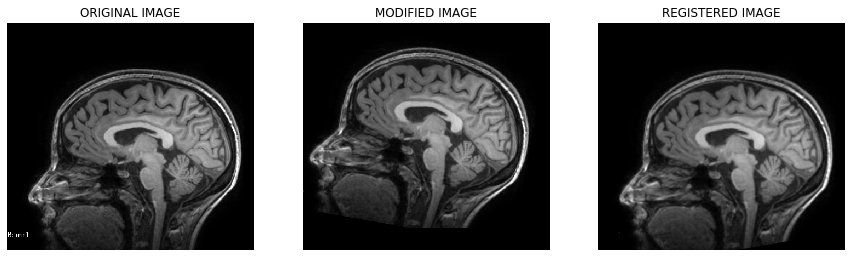

In [9]:
Registration(image_o,image_mod)   #Registration between the original and transformed image.

The results of the algorithm are the alignment of the images and the parameters for rotation, translation in x-axis and translation in y-axis that perform a better and more accurate registration between the images.


As we can see, the parameters optimized by the algorithm are 9.89 in rotation, 17.56 in x-axis translation and 39.43 in y-axis translation. On the one hand, the parameters obtained in rotation and y-axis translation are almost the same that the parameters applied to transform the image; on the other hand, the parameter of x-axis translation is slightly different to the one applied to transform. However, this difference does not affect to the final result of the registration.

### CONCLUSIONS

Regarding the results several conclusions can be deduced:

1. As it has been explained before, the results obtained when using the parameters (-10,-10,-40) are quite good. However, we can use other parameters to do the transformation, but with some of them we lose some info of the image and the result is a poor precise registration. Sometimes the obtained optimal parameters are not exactly the same that the ones applied to the original image, but they are good aproximations and the results are quite good.



2. The registration algorithm is not done from scratch but using Python functions. This is done because while trying to do functions by ourselves we found a lot of errors, this is why we decided to do it with already created functions. However, we have totally understood the process of the image registration. 